# Predicting Stock Prices of Netflix
use the last n days(like 60) to predict one day into the future, just the next day 

## Imports

If you want to use candle stick, you can also import mpl finance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

## Load Data

### Solution to RemoteDataError: Unable to read URL: 


*   !pip install --upgrade pandas-datareader
*   Go to Runtime -> Restart runtime. Then you can import pandas_datareader and check that it's the right version:



In [ ]:
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 35.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
web.__version__ # Should show 0.10.0

'0.10.0'

### Dataset

In [ ]:
# ticker symbol --> company name
company = 'NFLX'

start = dt.datetime(2011, 1, 1)
end = dt.datetime(2019, 1, 1)

data = web.DataReader(company, 'yahoo', start, end)

RemoteDataError: ignored

In [ ]:
data.shape

(2012, 6)

In [ ]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,25.838572,24.785713,25.000000,25.487143,39956000.0,25.487143
2011-01-04,26.414286,25.469999,25.907143,25.910000,44065700.0,25.910000
2011-01-05,26.112858,25.530001,25.878571,25.675714,31799600.0,25.675714
2011-01-06,25.670000,25.092857,25.168571,25.427143,31991400.0,25.427143
2011-01-07,25.792856,25.197144,25.524286,25.614286,22155000.0,25.614286
...,...,...,...,...,...,...
2018-12-24,250.649994,233.679993,242.000000,233.880005,9547600.0,233.880005
2018-12-26,254.500000,231.229996,233.919998,253.669998,14402700.0,253.669998
2018-12-27,255.589996,240.100006,250.110001,255.570007,12235200.0,255.570007


## Prepare Data

### reshape(-1, 1) :
-1 in reshape function is used when you dont know or want to explicitly tell the dimension of that axis. E.g,
If you have an array of shape (2,4) then reshaping it with (-1, 1), then the array will get reshaped in such a way that the resulting array has only 1 column and this is only possible by having 8 rows, hence, (8,1).

In [ ]:
# scale down all the values we have so
# they fit in between 0 and 1
# press all the values in together so
# they fit in between zero and one
scaler = MinMaxScaler(feature_range = (0, 1))

# not transforming the whole dataframe
# only interested in the closing price 
# after the markets have closed
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1)) 
# 'Adj Close' is also okay :  adjusted to stock splits

In [ ]:
scaled_data.shape

(2012, 1)

In [ ]:
scaled_data

array([[0.04328254],
       [0.04431068],
       [0.04374104],
       ...,
       [0.60270791],
       [0.60394788],
       [0.63210363]])

### range(start, stop, step) :
* start	--> Optional. An integer number specifying at which position to start. Default is 0
* stop -->	Required. An integer number specifying at which position to stop (not included).
* step -->	Optional. An integer number specifying the incrementation. Default is 1


In [ ]:
scaled_data[60]

array([0.06396341])

In [ ]:
scaled_data[60, 0] # first element of the array

0.06396340906103541

In [ ]:
# how many days we want to look into the 
# past to predict the next day
prediction_days = 60

x_train = []
y_train = []

# range : Create a sequence of numbers from 60(prediction_days) to 2011 (len(scaled_data))
for x in range(prediction_days, len(scaled_data)) :
  x_train.append(scaled_data[x-prediction_days : x, 0 ]) # first 60 days
  y_train.append(scaled_data[x, 0]) # 61.day

x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
y_train

array([0.06396341, 0.06390435, 0.06540141, ..., 0.60270791, 0.60394788,
       0.63210363])

In [ ]:
x_train.shape

(1952, 60)

In [ ]:
x_train

array([[0.04328254, 0.04431068, 0.04374104, ..., 0.06120549, 0.06374458,
        0.06376542],
       [0.04431068, 0.04374104, 0.04313666, ..., 0.06374458, 0.06376542,
        0.06396341],
       [0.04374104, 0.04313666, 0.04359168, ..., 0.06376542, 0.06396341,
        0.06390435],
       ...,
       [0.90872491, 0.89829423, 0.89807533, ..., 0.58038756, 0.54997066,
        0.59808821],
       [0.89829423, 0.89807533, 0.86549448, ..., 0.54997066, 0.59808821,
        0.60270791],
       [0.89807533, 0.86549448, 0.83558819, ..., 0.59808821, 0.60270791,
        0.60394788]])

In [ ]:
x_train[0] # from index 0 to 60

array([0.04328254, 0.04431068, 0.04374104, 0.04313666, 0.04359168,
       0.04657189, 0.04614466, 0.04692618, 0.0478258 , 0.04782233,
       0.04858648, 0.04761045, 0.04557154, 0.04456077, 0.0452103 ,
       0.04617592, 0.04488727, 0.05455733, 0.05702694, 0.0556723 ,
       0.05526244, 0.05469279, 0.05477268, 0.05775289, 0.05704084,
       0.05690537, 0.058524  , 0.05884008, 0.06157367, 0.0672979 ,
       0.06494986, 0.06388351, 0.06315757, 0.06311589, 0.05828433,
       0.05467195, 0.05605438, 0.05510266, 0.05309848, 0.0523899 ,
       0.05225096, 0.05195225, 0.05450523, 0.05335204, 0.04920128,
       0.04834682, 0.05078865, 0.05235864, 0.05119851, 0.05672476,
       0.05558894, 0.05560978, 0.05404673, 0.0552416 , 0.05821139,
       0.06087552, 0.06089983, 0.06120549, 0.06374458, 0.06376542])

In [ ]:
x_train[1] # from index 1 to 61

array([0.04431068, 0.04374104, 0.04313666, 0.04359168, 0.04657189,
       0.04614466, 0.04692618, 0.0478258 , 0.04782233, 0.04858648,
       0.04761045, 0.04557154, 0.04456077, 0.0452103 , 0.04617592,
       0.04488727, 0.05455733, 0.05702694, 0.0556723 , 0.05526244,
       0.05469279, 0.05477268, 0.05775289, 0.05704084, 0.05690537,
       0.058524  , 0.05884008, 0.06157367, 0.0672979 , 0.06494986,
       0.06388351, 0.06315757, 0.06311589, 0.05828433, 0.05467195,
       0.05605438, 0.05510266, 0.05309848, 0.0523899 , 0.05225096,
       0.05195225, 0.05450523, 0.05335204, 0.04920128, 0.04834682,
       0.05078865, 0.05235864, 0.05119851, 0.05672476, 0.05558894,
       0.05560978, 0.05404673, 0.0552416 , 0.05821139, 0.06087552,
       0.06089983, 0.06120549, 0.06374458, 0.06376542, 0.06396341])

In [ ]:
# reshaping x_train so it can work with neural networks
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
x_train.shape

(1952, 60, 1)

In [ ]:
"""
1952 tane bu yapıdan - 60 rows,1 col
        [[0.04328254],
        [0.04431068],
        [0.04374104],
        ...,
        [0.06120549],
        [0.06374458],
        [0.06376542]]
"""
x_train

array([[[0.04328254],
        [0.04431068],
        [0.04374104],
        ...,
        [0.06120549],
        [0.06374458],
        [0.06376542]],

       [[0.04431068],
        [0.04374104],
        [0.04313666],
        ...,
        [0.06374458],
        [0.06376542],
        [0.06396341]],

       [[0.04374104],
        [0.04313666],
        [0.04359168],
        ...,
        [0.06376542],
        [0.06396341],
        [0.06390435]],

       ...,

       [[0.90872491],
        [0.89829423],
        [0.89807533],
        ...,
        [0.58038756],
        [0.54997066],
        [0.59808821]],

       [[0.89829423],
        [0.89807533],
        [0.86549448],
        ...,
        [0.54997066],
        [0.59808821],
        [0.60270791]],

       [[0.89807533],
        [0.86549448],
        [0.83558819],
        ...,
        [0.59808821],
        [0.60270791],
        [0.60394788]]])

## Build the Model

In [ ]:
model = Sequential()

In [ ]:
# more units more training
# if you use to many units --> overfit
# return_sequences = True, feed back
# the information, LSTM is not
# feed forward like ordinary Dense layer
# input_shape parameter --> only the first layer
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))


model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# dense layer : one unit,next closing value prediction
model.add(Dense(units =1)) 

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


# epochs = sees the same data 25 times
# batch_size = 32 units at once all the time
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

## Testing the Model : 
not just predicting the next day that we dont know yet, we are also gonna test how well would this model perform based on the past data that we already have

### Test The Model Accuracy on Existing Data

#### Load / Prepare test data

In [ ]:
# this data has to be the data
# that the model has not seen before
# we have this data but the model has 
# never seen that data
test_start = dt.datetime(2019, 1, 1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

# Comnbine train and test data
total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)
total_dataset

Date
2011-01-03     25.487143
2011-01-04     25.910000
2011-01-05     25.675714
2011-01-06     25.427143
2011-01-07     25.614286
                 ...    
2022-11-25    285.540009
2022-11-28    281.170013
2022-11-29    280.959991
2022-11-30    305.529999
2022-12-01    316.950012
Name: Close, Length: 3000, dtype: float64

In [ ]:
actual_prices

array([267.66000366, 271.20001221, 297.57000732, 315.33999634,
       320.26998901, 319.95999146, 324.66000366, 337.58999634,
       332.94000244, 354.64001465, 351.39001465, 353.19000244,
       339.1000061 , 325.16000366, 321.98999023, 326.67001343,
       338.04998779, 335.66000366, 328.8999939 , 340.66000366,
       339.5       , 339.8500061 , 351.33999634, 355.80999756,
       352.19000244, 344.70999146, 347.57000732, 345.73001099,
       359.97000122, 351.76998901, 359.07000732, 356.86999512,
       361.92001343, 359.91000366, 356.97000122, 363.01998901,
       363.91000366, 364.97000122, 362.86999512, 358.1000061 ,
       357.32000732, 351.04000854, 354.29998779, 359.60998535,
       352.6000061 , 349.6000061 , 358.85998535, 356.26998901,
       361.20999146, 358.82000732, 361.45999146, 363.44000244,
       358.77999878, 375.22000122, 377.86999512, 361.01000977,
       366.23001099, 359.97000122, 353.36999512, 354.60998535,
       356.55999756, 366.95999146, 367.72000122, 369.75

In [ ]:
test_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,269.750000,256.579987,259.279999,267.660004,11679500,267.660004
2019-01-03,275.790009,264.429993,270.200012,271.200012,14969600,271.200012
2019-01-04,297.799988,278.540009,281.880005,297.570007,19330100,297.570007
2019-01-07,316.799988,301.649994,302.100006,315.339996,18620100,315.339996
2019-01-08,320.589996,308.010010,319.980011,320.269989,15359200,320.269989
...,...,...,...,...,...,...
2022-11-25,289.209991,284.170013,289.000000,285.540009,3236000,285.540009
2022-11-28,289.549988,280.529999,284.000000,281.170013,4703400,281.170013
2022-11-29,282.959991,275.940002,282.500000,280.959991,5786900,280.959991


In [ ]:
# model is gonna see this as an input
# so that it can predict the next price
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days : ].values.reshape(-1, 1) 
model_inputs = scaler.fit_transform(model_inputs)
model_inputs

array([[0.37554252],
       [0.35212824],
       [0.34784514],
       ...,
       [0.2181337 ],
       [0.2649052 ],
       [0.28664436]])

In [ ]:
model_inputs.shape

(1048, 1)

#### Make predictions on test data

In [ ]:
x_test = []

for x in range(prediction_days, len(model_inputs)) :
  x_test.append(model_inputs[x-prediction_days : x, 0 ]) # first 60 days

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test

array([[[0.37554252],
        [0.35212824],
        [0.34784514],
        ...,
        [0.16980128],
        [0.17077208],
        [0.19281582]],

       [[0.35212824],
        [0.34784514],
        [0.36042792],
        ...,
        [0.17077208],
        [0.19281582],
        [0.19281582]],

       [[0.34784514],
        [0.36042792],
        [0.30366256],
        ...,
        [0.19281582],
        [0.19281582],
        [0.19955459]],

       ...,

       [[0.11372117],
        [0.09902536],
        [0.11914645],
        ...,
        [0.23819768],
        [0.22685223],
        [0.2185335 ]],

       [[0.09902536],
        [0.11914645],
        [0.11625296],
        ...,
        [0.22685223],
        [0.2185335 ],
        [0.2181337 ]],

       [[0.11914645],
        [0.11625296],
        [0.12792205],
        ...,
        [0.2185335 ],
        [0.2181337 ],
        [0.2649052 ]]])

In [ ]:
predicted_prices = model.predict(x_test)
predicted_prices

31/31 [==============================] - 1s 17ms/step


array([[0.17607796],
       [0.17626876],
       [0.17848998],
       [0.18418786],
       [0.19436821],
       [0.20845102],
       [0.2247721 ],
       [0.24192868],
       [0.25957364],
       [0.2763553 ],
       [0.2930857 ],
       [0.30910105],
       [0.32380807],
       [0.335485  ],
       [0.34256047],
       [0.34497213],
       [0.3440381 ],
       [0.3419537 ],
       [0.33966398],
       [0.33711812],
       [0.3354348 ],
       [0.33480203],
       [0.33512303],
       [0.33709168],
       [0.34088504],
       [0.3457107 ],
       [0.35023448],
       [0.35409722],
       [0.35700125],
       [0.36012286],
       [0.36301833],
       [0.36608273],
       [0.3691032 ],
       [0.37231517],
       [0.37545446],
       [0.37807012],
       [0.38051784],
       [0.38292962],
       [0.38535282],
       [0.38752604],
       [0.3889254 ],
       [0.38941962],
       [0.388622  ],
       [0.38699856],
       [0.3854075 ],
       [0.38363376],
       [0.38147995],
       [0.379

In [ ]:
# already scaled, reverse scale them
predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices

array([[258.86728],
       [258.9675 ],
       [260.13437],
       [263.12753],
       [268.4755 ],
       [275.8735 ],
       [284.44727],
       [293.46   ],
       [302.72922],
       [311.54495],
       [320.33377],
       [328.74695],
       [336.47287],
       [342.60696],
       [346.32385],
       [347.59076],
       [347.10007],
       [346.00513],
       [344.80228],
       [343.46487],
       [342.5806 ],
       [342.2482 ],
       [342.4168 ],
       [343.451  ],
       [345.44373],
       [347.97873],
       [350.35516],
       [352.38434],
       [353.90988],
       [355.54974],
       [357.0708 ],
       [358.68057],
       [360.26727],
       [361.9546 ],
       [363.60373],
       [364.97778],
       [366.26364],
       [367.53058],
       [368.80353],
       [369.94516],
       [370.68027],
       [370.9399 ],
       [370.5209 ],
       [369.66806],
       [368.83228],
       [367.90048],
       [366.76904],
       [365.89725],
       [365.31128],
       [365.20178],


#### Plot the Test Predictions

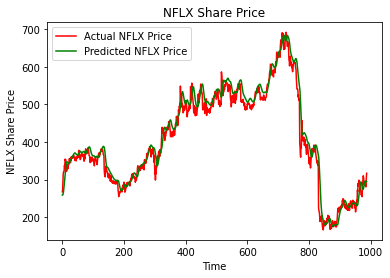

In [ ]:
plt.plot(actual_prices,color='red', label = f"Actual {company} Price")
plt.plot(predicted_prices,color='green', label = f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

#### Predicting the next day

In [ ]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days: len(model_inputs + 1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [ ]:
print(scaler.inverse_transform(real_data[-1]))

[[233.57000732]
 [236.52999878]
 [218.13000488]
 [224.11999512]
 [235.38000488]
 [240.13000488]
 [243.63000488]
 [242.8500061 ]
 [236.86999512]
 [237.05000305]
 [226.41000366]
 [224.07000732]
 [224.36000061]
 [245.19999695]
 [239.71000671]
 [235.44000244]
 [239.03999329]
 [240.74000549]
 [236.72999573]
 [240.02000427]
 [224.75      ]
 [229.97999573]
 [214.28999329]
 [220.86999512]
 [232.50999451]
 [230.        ]
 [245.1000061 ]
 [240.86000061]
 [272.38000488]
 [268.16000366]
 [289.57000732]
 [282.45001221]
 [291.01998901]
 [298.61999512]
 [296.94000244]
 [295.72000122]
 [291.88000488]
 [286.75      ]
 [273.        ]
 [269.05999756]
 [260.79000854]
 [258.6000061 ]
 [263.45999146]
 [254.66000366]
 [274.97000122]
 [290.13000488]
 [299.26998901]
 [310.20001221]
 [306.01998901]
 [295.27999878]
 [287.98001099]
 [285.04998779]
 [286.69000244]
 [291.5       ]
 [285.54000854]
 [281.17001343]
 [280.95999146]
 [305.52999878]
 [316.95001221]]


In [ ]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Neftlix Stock Closing Value Prediction of tomorrow : {prediction}')

1/1 [==============================] - 0s 29ms/step
Neftlix Stock Closing Value Prediction of tomorrow : [[295.69553]]


## Result

* if you decrease the 60 days to 10/20 days you are going to be more sensitive to short term fluctuations
* if you increase the days you are going to look more for the long term stuff